In [1]:
def parse_demanda(fname):
    region = int(fname.split('-')[-1].split('.')[0])
    open_func = gzip.open if fname.endswith('gz') else open
    
    with open_func(fname) as f:
        res = json.load(f)
        for doc in res:
            doc['region'] = region
            doc['fecha'] = datetime.strptime(doc['fecha'][:19], '%Y-%m-%dT%H:%M:%S')
    return res

In [2]:
from datetime import timedelta, datetime
import gzip

def parse_clima(fname):
    open_func = gzip.open if fname.endswith('gz') else open

    with open_func(fname) as f:
        clima_content = f.read()
    
    if isinstance(clima_content, bytes): clima_content = clima_content.decode('utf8')
        
    data = clima_content.split(';')[0]
    parsed_data = json.loads(data[6:].replace("'", '"'))
    keys = ['hour', 'ufs_edesur', 'ufs_edenor', 'codigo', 'estado_cielo', 'temperatura']
    parsed_data = [dict(zip(keys, row)) for row in parsed_data]

    fname_date = parse_fname_date(fname)

    hour, minute = map(int, parsed_data[-1]['hour'].split(':'))
    parsed_data[-1]['datetime'] = fname_date.replace(hour=hour, minute=minute)

    for i in range(len(parsed_data)-2, -1, -1):
        current_row = parsed_data[i]
        current_time = datetime.strptime(current_row['hour'], '%H:%M')

        prev_row = parsed_data[i+1]
        prev_time = datetime.strptime(prev_row['hour'], '%H:%M')

        delta = (prev_time - current_time)
        if delta.total_seconds() < 0:
            delta += timedelta(days=1)

        current_row['datetime'] = prev_row['datetime'] - delta
    
    return parsed_data

In [100]:
import json
import re
import os
from datetime import timedelta

def parse_fname_date(fname):
    date_pat = re.compile('(\d{4}-\d{2}-\d{2}T\d{2}:\d{2})')
    if date_pat.search(fname) is None:
        raise ValueError('old fname')
        
    return datetime.strptime(date_pat.search(fname).group(0), '%Y-%m-%dT%H:%M')

def parse_cortes(fname):
    """
    convierte el json crudo de cortes en una lista de diccionarios (tambien parsea la descripccion)
    """
    open_func = gzip.open if fname.endswith('gz') else open
    with open_func(fname) as f:
        contents = f.read()
        
    if len(contents) == 0: return []
        
    if isinstance(contents, bytes): contents = contents.decode('utf8')
        
    var_pat = re.compile('addressPoints_Cuadro_D.*?=.*?(?P<lista>.*?);?$')
    lista = var_pat.search(contents).groupdict()['lista'].strip()[1:-1].strip()

    corte_pat = re.compile('(\[.*?\])')
    cortes = []
    fname_date = parse_fname_date(fname)
    keys = ['latitud', 'longitud', 'misc', 'descr']
    for corte_match in corte_pat.finditer(lista):
        corte = json.loads(corte_match.group(0))
        corte = dict(zip(keys, corte))
        
        lines = corte['descr'].split(',')
        descr_dict = {'tipo': lines[0], 'empresa': lines[1].strip()}
        for line in lines[2:]:
            colon_pos = line.find(':')
            k = line[:colon_pos].strip()
            v = line[colon_pos+1:].strip()
            descr_dict[k.strip().lower()] = v.strip()

        corte.update(descr_dict)
        corte['fname_date'] = fname_date
        if fname_date.minute > 30:
            corte['date_hour'] = fname_date.replace(minute=0) + timedelta(hours=1)
        else:
            corte['date_hour'] = fname_date.replace(minute=0)

        
        cortes.append(corte)
        
    return cortes

In [101]:
cortes = []
demanda = []
clima = []
for fname in os.listdir('data'):
    try:
        parse_fname_date(fname)
    except ValueError:
        continue
        
    if fname.startswith('cortes'):
        parsing_func = parse_cortes
        output_list = cortes
    elif fname.startswith('clima'):
        parsing_func = parse_clima
        output_list = clima
    else:
        parsing_func = parse_demanda
        output_list = demanda
        
    fname = 'data/' + fname
    output_list.extend(parsing_func(fname))
    

In [232]:
import pandas as pd

demanda_df = pd.DataFrame(demanda)
demanda_df.drop_duplicates(subset=['fecha', 'region'], inplace=True)
demanda_df['fecha'] = demanda_df.fecha.apply(lambda x: x - timedelta(days=1))
demanda_df['dem'] = demanda_df.demAyer
demanda_df.drop(columns=['demHoy', 'demAyer', 'demSemanaAnt'], inplace=True)
demanda_df.head()

,fecha,region,dem
0,2024-03-03 00:00:00,1077,2814
1,2024-03-03 00:05:00,1077,2794
2,2024-03-03 00:10:00,1077,2771
3,2024-03-03 00:15:00,1077,2737
4,2024-03-03 00:20:00,1077,2717


In [233]:
demanda_df.fecha.sort_values().diff().value_counts()

0 days 00:00:00    9506
0 days 00:05:00    9504
1 days 00:00:00       1
Name: fecha, dtype: int64

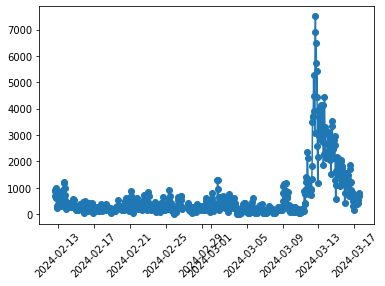

In [104]:
from collections import Counter
import matplotlib.pyplot as plt


x, y = zip(*sorted(Counter([e['date_hour'] for e in cortes]).items()))
plt.plot(x, y, '-o')
plt.xticks(rotation=45);

In [234]:
len(demanda_df)

19012

In [235]:
region2str = {
    1077: 'EDESUR',  1078: 'EDENOR', 
}

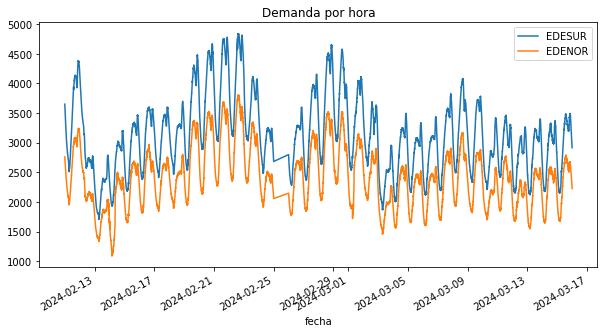

In [238]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.title('Demanda por hora')
for region in demanda_df.region.unique():
    demanda_df[demanda_df.region==region].set_index('fecha').dem.plot(label=region2str[region])
    
plt.legend(loc='best')

In [239]:
cortes_df = pd.DataFrame(cortes)
cortes_df['usuarios afectados'] = cortes_df['usuarios afectados'].apply(int)
cortes_df['region'] = cortes_df.empresa.apply(lambda e: 1077 if e == 'EDESUR S.A.' else 1078)


In [240]:
s = cortes_df.date_hour.sort_values().diff().value_counts()[1:].sort_values()
s

0 days 15:00:00      1
0 days 07:00:00      1
0 days 02:00:00     10
0 days 01:00:00    771
Name: date_hour, dtype: int64

In [241]:
clima_df = pd.DataFrame(clima)
clima_df['date_hour'] = clima_df.datetime.apply(lambda x: x.replace(minute=0))
clima_df['temperatura'] = clima_df['temperatura'].astype('int')

In [242]:
clima_df.head()

,hour,ufs_edesur,ufs_edenor,codigo,estado_cielo,temperatura,datetime,date_hour
0,19:55,3732,3137,04d,Muy Nuboso,24,2024-02-26 19:55:00,2024-02-26 19:00:00
1,20:00,3732,3137,04d,Muy Nuboso,24,2024-02-26 20:00:00,2024-02-26 20:00:00
2,20:05,3732,3137,04d,Muy Nuboso,24,2024-02-26 20:05:00,2024-02-26 20:00:00
3,20:10,3732,3137,04d,Muy Nuboso,24,2024-02-26 20:10:00,2024-02-26 20:00:00
4,20:15,3732,3137,04d,Muy Nuboso,24,2024-02-26 20:15:00,2024-02-26 20:00:00


In [243]:
clima_df_hour = (
    clima_df.groupby('date_hour')
            .agg({'estado_cielo': pd.Series.mode, 'ufs_edesur': 'mean', 
                  'ufs_edenor': 'mean', 'temperatura': 'mean'})
           .reset_index()
)

In [244]:
len(clima_df_hour)

802

In [248]:
clima_df_hour.head()

,date_hour,estado_cielo,ufs_edesur,ufs_edenor,temperatura
0,2024-02-11 15:00:00,Cielo Claro,24617.105263,2647.0,33.105263
1,2024-02-11 16:00:00,Nubes Dispersas,18497.666667,2647.0,32.416667
2,2024-02-11 17:00:00,Nubes Dispersas,17725.666667,2647.0,32.000000
3,2024-02-11 18:00:00,Algo De Nubes,16190.750000,2647.0,32.000000
4,2024-02-11 19:00:00,Cielo Claro,24054.750000,3202.5,31.166667


In [249]:
demanda_df['date_hour'] = demanda_df.fecha.apply(lambda x: x.replace(minute=0))
demanda_df_hour = (
    demanda_df.groupby(['date_hour', 'region'])
            .agg({'dem': 'mean'})
            .reset_index()
)

In [263]:
merged = (
    cortes_df.merge(clima_df_hour, left_on='date_hour', right_on='date_hour')
             .merge(demanda_df_hour, left_on=('date_hour', 'region'), right_on=('date_hour', 'region'))
)

In [264]:
len(cortes_df), len(clima_df), len(merged)

(481339, 19584, 438179)

In [265]:
merged['not_dem'] = merged.dem.isna()
merged.not_dem.sum()

0

In [178]:
(len(cortes_df) - len(merged)) #/ len(cortes_df)

13898

In [266]:
merged = (
    cortes_df.merge(demanda_df_hour, 
                    left_on=('date_hour', 'region'), right_on=('date_hour', 'region'), 
                    how='left')
            #.merge(clima_df_hour, 
            #        left_on='date_hour', right_on='date_hour',how='left')
)

In [267]:
merged['not_dem'] = merged.dem.isna()
merged.not_dem.sum()

36479

<AxesSubplot:xlabel='fname_date'>

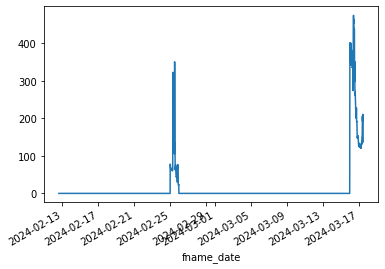

In [268]:

merged.groupby('fname_date').not_dem.sum().plot()

In [253]:
len(cortes_df), len(clima_df), len(merged)

(481339, 19584, 481339)

In [254]:
len(cortes_df) - len(merged)

0

In [255]:
merged['not_clima'] = merged.estado_cielo.isna()
merged.not_clima.sum()

13722

In [257]:
merged['not_dem'] = merged.dem.isna()
merged.not_dem.sum()

36479

In [172]:
37787 / len(merged) 

0.07850392343026433

<AxesSubplot:xlabel='date_hour'>

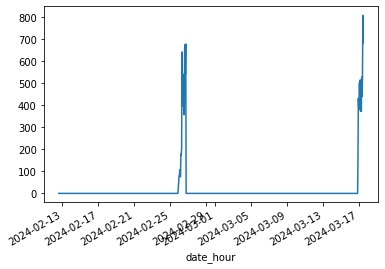

In [144]:
merged.groupby('date_hour').not_clima.sum().plot()

<AxesSubplot:xlabel='fname_date'>

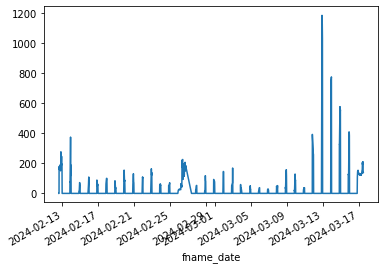

In [158]:
s = merged.groupby('fname_date').not_dem.sum()
s.plot()

In [163]:
demanda_df['hour'] = demanda_df.fecha.apply(lambda x:x.hour)
demanda_df.groupby('hour').demHoy.count()

hour
0     755
1     792
2     792
3     792
4     792
5     792
6     792
7     792
8     792
9     792
10    792
11    792
12    792
13    792
14    792
15    786
16    780
17    780
18    780
19    780
20    474
21    342
22      0
23      0
Name: demHoy, dtype: int64

<AxesSubplot:xlabel='hour'>

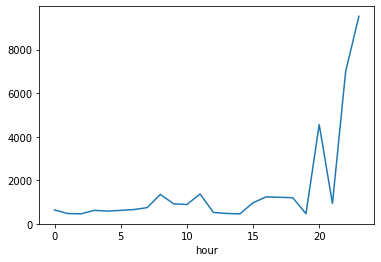

In [159]:
merged['hour'] = merged.fname_date.apply(lambda x: x.hour)
s = merged.groupby('hour').not_dem.sum()
s.plot()

<AxesSubplot:xlabel='date_hour'>

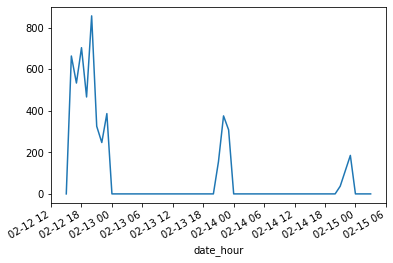

In [157]:
s = merged.groupby('date_hour').not_dem.sum()[:60]
s.plot()

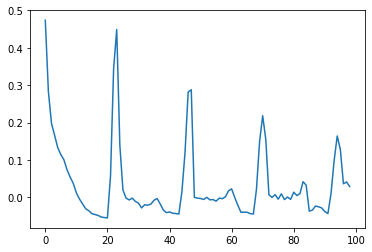

In [153]:
plt.plot([s.autocorr(lag=i) for i in range(1, 100)])

In [134]:
pd.options.display.max_columns = 1000

In [135]:
merged.head()

,latitud,longitud,misc,descr,tipo,empresa,partido,localidad,subestacion,alimentador,usuarios afectados,hora estimada de normalizacion,fname_date,date_hour,region,estado_cielo,ufs_edesur,ufs_edenor,temperatura,demHoy,demAyer,demSemanaAnt
0,-34.801746,-58.276177,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,FLORENCIO VARELA,FLORENCIO VARELA,S/D,R:286-5-52/286-5-52,441,Sin datos,2024-03-07 17:18:00,2024-03-07 17:00:00,1077,Cielo Claro,4283.833333,887.583333,27.916667,3518.333333,3084.25,4071.75
1,-34.800887,-58.271918,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,FLORENCIO VARELA,FLORENCIO VARELA,S/D,R:286-5-52/286-5-52,418,Sin datos,2024-03-07 17:18:00,2024-03-07 17:00:00,1077,Cielo Claro,4283.833333,887.583333,27.916667,3518.333333,3084.25,4071.75
2,-34.611951,-58.429488,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,ALMAGRO,CABALLITO,R:122-4-45/122-4-45,1,2024-03-07 18:30,2024-03-07 17:18:00,2024-03-07 17:00:00,1077,Cielo Claro,4283.833333,887.583333,27.916667,3518.333333,3084.25,4071.75
3,-34.730665,-58.456921,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,LOMAS DE ZAMORA,INGENIERO BUDGE,TRANSRADIO,R:281-2-22/281-2-22,239,2024-03-07 17:44,2024-03-07 17:18:00,2024-03-07 17:00:00,1077,Cielo Claro,4283.833333,887.583333,27.916667,3518.333333,3084.25,4071.75
4,-34.731269,-58.456457,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,LOMAS DE ZAMORA,ZONA RURAL,TRANSRADIO,R:281-2-22/281-2-22,254,2024-03-07 17:44,2024-03-07 17:18:00,2024-03-07 17:00:00,1077,Cielo Claro,4283.833333,887.583333,27.916667,3518.333333,3084.25,4071.75


# Preguntas

1) Sube la demanda cuando aumenta la temperatura?

2) Cuales son las zonas con mas demanda (con la data que tenemos no la podemos contestar)

3) Cuales son las zonas con mas cortes. Coinciden con las de mayor demanda?

4) El estado del cielo correlaciona con la demanda y con los cortes?

5) Hay algun horario de mayor cantidad de cortes?

6) Cuales son las zonas con mas usuarios afectados? 


### 1) Sube la demanda cuando aumenta la temperatura?


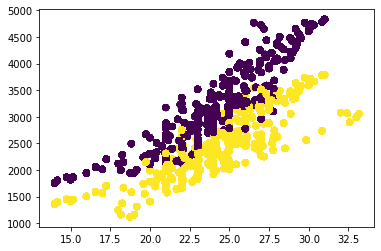

In [169]:
plt.scatter(merged.temperatura, merged.demHoy, c=merged.region)

### 3) Cuales son las zonas con mas cortes. Coinciden con las de mayor demanda?


In [170]:
cortes_df['partido_localidad'] = cortes_df.partido + "/" + cortes_df.localidad

In [171]:
cortes_df.partido_localidad.value_counts().head(5)

TIGRE/DELTA 1RA SECCION (TI)           8738
SAN FERNANDO/DELTA 2DA SECCION (SF)    7733
FLORENCIO VARELA/FLORENCIO VARELA      6085
SAN FERNANDO/DELTA 3RA SECCION (SF)    4221
CAPITAL RP/CABALLITO RP                3779
Name: partido_localidad, dtype: int64

### 4) El estado del cielo correlaciona con la demanda y con los cortes?


In [125]:
range(a)

TypeError: 'slice' object cannot be interpreted as an integer

In [172]:
clima_df.estado_cielo.value_counts()

Cielo Claro                     7235
Algo De Nubes                   2566
Nubes Dispersas                 2435
Muy Nuboso                      2152
Nubes                            970
Lluvia Moderada                  289
Lluvia Ligera                    258
Tormenta Con Lluvia               90
Tormenta Con Lluvia Ligera        82
Lluvia De Gran Intensidad         35
Tormenta Con Lluvia Intensa       16
Name: estado_cielo, dtype: int64

<module 'pandas' from '/Users/przivic/miniconda3/envs/mlp2022/lib/python3.9/site-packages/pandas/__init__.py'>

In [174]:
merged

,latitud,longitud,misc,descr,tipo,empresa,partido,localidad,subestacion,alimentador,usuarios afectados,hora estimada de normalizacion,date_hour,region,estado_cielo,ufs_edesur,ufs_edenor,temperatura,demHoy,demAyer,demSemanaAnt
0,-34.658704,-58.354090,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,AVELLANEDA,DOCK SUD,9 DE JULIO,R:279-2-23/279-2-23,341,2024-02-15 02:56,2024-02-14 23:00:00,1077,Cielo Claro,1335.50,92.000000,21.916667,NaN,2433.166667,4881.833333
1,-34.640539,-58.520141,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,LINIERS,LURO,R:038-3-35/038-3-35,578,2024-02-15 02:28,2024-02-14 23:00:00,1077,Cielo Claro,1335.50,92.000000,21.916667,NaN,2433.166667,4881.833333
2,-34.639500,-58.413200,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,CAPITAL,NUEVA POMPEYA,NaN,NaN,1,NaN,2024-02-14 23:00:00,1077,Cielo Claro,1335.50,92.000000,21.916667,NaN,2433.166667,4881.833333
3,-34.611300,-58.388800,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,CAPITAL,MONSERRAT,NaN,NaN,16,NaN,2024-02-14 23:00:00,1077,Cielo Claro,1335.50,92.000000,21.916667,NaN,2433.166667,4881.833333
4,-34.614700,-58.391900,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,CAPITAL,MONSERRAT,NaN,NaN,56,NaN,2024-02-14 23:00:00,1077,Cielo Claro,1335.50,92.000000,21.916667,NaN,2433.166667,4881.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113095,-34.483742,-58.608521,12,"<b>CORTE DE MEDIA TENSION</b>, EDENOR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDENOR S.A.,TIGRE,DON TORCUATO,S/D,R:BANCALARI/157-TR1/157-5513,3,Sin datos,2024-02-18 09:00:00,1078,Nubes Dispersas,2317.25,1287.416667,26.000000,2136.25,2133.416667,2251.416667
113096,-34.687400,-58.828100,22,"<b>CORTE DE BAJA TENSION</b>, EDENOR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDENOR S.A.,MERLO,MARIANO ACOSTA,NaN,NaN,6,NaN,2024-02-18 09:00:00,1078,Nubes Dispersas,2317.25,1287.416667,26.000000,2136.25,2133.416667,2251.416667
113097,-34.774600,-58.653500,22,"<b>CORTE DE BAJA TENSION</b>, EDENOR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDENOR S.A.,LA MATANZA,GONZALEZ CATAN,NaN,NaN,85,NaN,2024-02-18 09:00:00,1078,Nubes Dispersas,2317.25,1287.416667,26.000000,2136.25,2133.416667,2251.416667
113098,-34.582700,-58.757700,22,"<b>CORTE DE BAJA TENSION</b>, EDENOR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDENOR S.A.,MORENO,TRUJUI,NaN,NaN,22,NaN,2024-02-18 09:00:00,1078,Nubes Dispersas,2317.25,1287.416667,26.000000,2136.25,2133.416667,2251.416667


In [67]:
merged.to_csv('a.csv')

In [68]:
a = pd.read_csv('a.csv')

([<matplotlib.axis.XTick at 0x7fe742faa430>], [Text(1, 0, 'demHoy')])

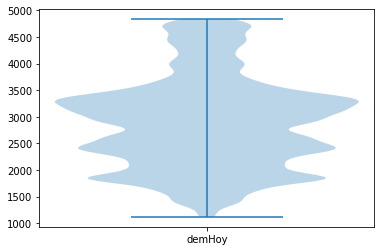

In [178]:
plt.violinplot(merged.demHoy.dropna())
plt.xticks([1], ['demHoy'])

In [128]:
merged.groupby('binned_temperature')['usuarios afectados'].mean().sort_index()

binned_temperature
14     53.000900
16     70.157202
18     43.814406
20     45.857491
22     45.459607
24     72.790103
26     79.195780
28     85.515493
30    100.701402
32     89.562182
Name: usuarios afectados, dtype: float64

In [185]:
3 // 2 * 2

2

In [181]:
[i // 2 * 2 for i in range(20)]

[0, 0, 2, 2, 4, 4, 6, 6, 8, 8, 10, 10, 12, 12, 14, 14, 16, 16, 18, 18]

In [187]:
merged.temperatura.apply(lambda x: int(x) // 2 * 2).unique()

array([20, 22, 24, 18, 30, 26, 28, 16, 14, 32])

<AxesSubplot:xlabel='binned_temperature'>

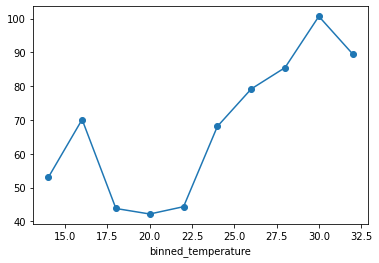

In [190]:
merged['binned_temperature'] = merged.temperatura.apply(lambda x: int(x) // 2 * 2)

merged.groupby('binned_temperature')['usuarios afectados'].mean().sort_index().plot(marker='o')

([<matplotlib.axis.XTick at 0x7fe718637190>],
 [Text(1, 0, 'usuarios afectados')])

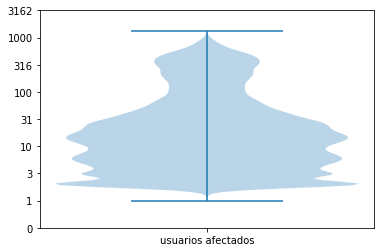

In [206]:
plt.violinplot(np.log10(merged['usuarios afectados'] + 1))
plt.yticks(plt.yticks()[0], [int(e) for e in 10**plt.yticks()[0]])
plt.xticks([1], ['usuarios afectados'])

([<matplotlib.axis.XTick at 0x7fe74327ecd0>],
 [Text(1, 0, 'usuarios afectados')])

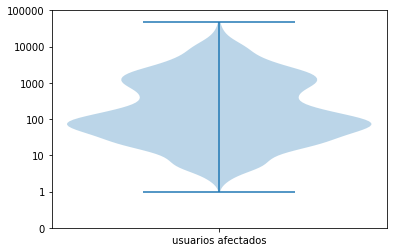

In [217]:
u = merged.groupby(['partido', 'date_hour'])['usuarios afectados'].sum()
plt.violinplot(np.log10(u + 1))
plt.yticks(plt.yticks()[0], [int(e) for e in 10**plt.yticks()[0]])
plt.xticks([1], ['usuarios afectados'])

Text(0, 0.5, '# muestras por bucket')

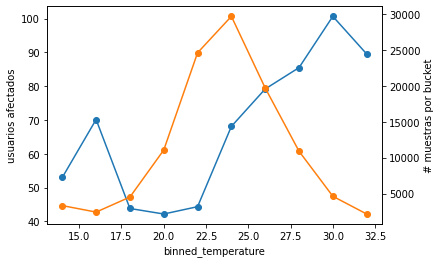

In [194]:
g = merged.groupby('binned_temperature')['usuarios afectados']
g.mean().sort_index().plot(marker='o')


plt.ylabel('usuarios afectados')
plt.xlabel('temperatura')

g.count().sort_index().plot(secondary_y=True, marker='o')

plt.ylabel('# muestras por bucket')

Text(0.5, 0, 'temperatura')

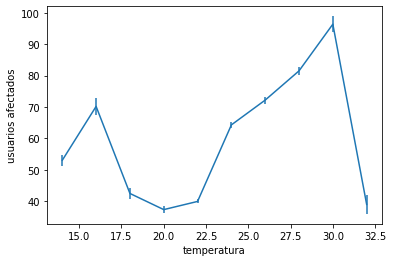

In [227]:
g = merged[~merged.demHoy.isna()].groupby('binned_temperature')['usuarios afectados']
mean = g.mean().sort_index().dropna()
std = g.std().sort_index().dropna() / (g.count().sort_index().dropna())**0.5


plt.errorbar(mean.index, mean.values, yerr=std.values)
plt.ylabel('usuarios afectados')
plt.xlabel('temperatura')

In [ ]:
g = merged.groupby('binned_temperature')['usuarios afectados']
mean = g.mean().sort_index().dropna()
std = g.std().sort_index().dropna() / (g.count().sort_index().dropna())**0.5


plt.errorbar(mean.index, mean.values, yerr=std.values)
plt.ylabel('usuarios afectados')
plt.xlabel('temperatura')

In [223]:
merged['binnedDemanda'] = merged.demHoy.apply(lambda x: int(round(x, 0))//100*100 if not np.isnan(x) else x )

Text(0.5, 0, 'demanda')

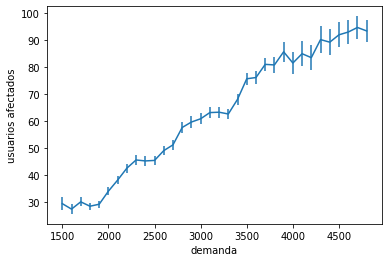

In [224]:
g = merged[~merged.demHoy.isna()].groupby('binnedDemanda')['usuarios afectados']
mean = g.mean().sort_index().rolling(5).mean().dropna()
std = g.std().sort_index().rolling(5).mean().dropna() / (g.count().sort_index().rolling(5).mean().dropna())**0.5


plt.errorbar(mean.index, mean.values, yerr=std.values)
plt.ylabel('usuarios afectados')
plt.xlabel('demanda')

Text(0.5, 0, 'demanda')

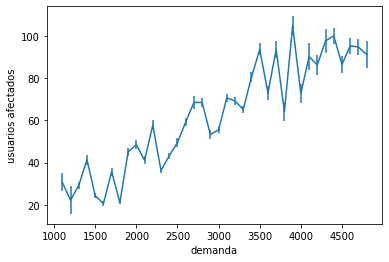

In [226]:
g = merged[~merged.demHoy.isna()].groupby('binnedDemanda')['usuarios afectados']
mean = g.mean().sort_index().dropna()
std = g.std().sort_index().dropna() / (g.count().sort_index().dropna())**0.5


plt.errorbar(mean.index, mean.values, yerr=std.values)
plt.ylabel('usuarios afectados')
plt.xlabel('demanda')

In [229]:
merged.to_csv('a.csv')
a = pd.read_csv('a.csv')

In [235]:
clima_df.head()

,hour,ufs_edesur,ufs_edenor,codigo,estado_cielo,temperatura,datetime,date_hour
0,01:20,41164,1969,01n,Cielo Claro,26,2024-02-11 01:20:00,2024-02-11 01:00:00
1,01:25,41164,1969,01n,Cielo Claro,26,2024-02-11 01:25:00,2024-02-11 01:00:00
2,01:30,38574,1969,01n,Cielo Claro,26,2024-02-11 01:30:00,2024-02-11 01:00:00
3,01:35,38574,1969,01n,Cielo Claro,25,2024-02-11 01:35:00,2024-02-11 01:00:00
4,01:40,38574,1969,01n,Cielo Claro,25,2024-02-11 01:40:00,2024-02-11 01:00:00


<AxesSubplot:xlabel='temperatura'>

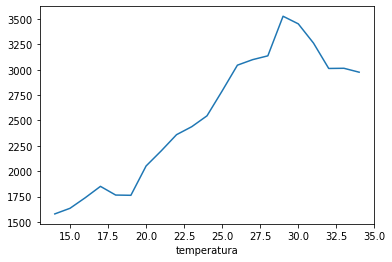

In [240]:
clima_df.merge(demanda_df, on='date_hour').groupby('temperatura').demHoy.mean().sort_index().plot()

In [239]:
clima_df.merge(demanda_df, on='date_hour').groupby('estado_cielo').demHoy.mean().sort_values(ascending=False)

estado_cielo
Nubes                           3080.761733
Algo De Nubes                   2927.881699
Nubes Dispersas                 2847.139645
Muy Nuboso                      2759.567203
Cielo Claro                     2686.762961
Lluvia De Gran Intensidad       2490.611538
Lluvia Ligera                   2465.537234
Lluvia Moderada                 2454.179167
Tormenta Con Lluvia Ligera      2068.166667
Tormenta Con Lluvia Intensa     2032.583333
Tormenta Con Lluvia             2032.557087
Name: demHoy, dtype: float64

In [243]:
clima_df.groupby('estado_cielo').temperatura.mean().sort_values(ascending=False)

estado_cielo
Algo De Nubes                   28.055339
Nubes Dispersas                 27.064066
Cielo Claro                     26.048100
Muy Nuboso                      25.470725
Nubes                           24.700000
Lluvia Ligera                   24.647287
Lluvia Moderada                 23.688581
Tormenta Con Lluvia Ligera      22.000000
Lluvia De Gran Intensidad       21.028571
Tormenta Con Lluvia             20.288889
Tormenta Con Lluvia Intensa     20.000000
Name: temperatura, dtype: float64

In [ ]:
clima_df.merge(demanda_df, on='date_hour').groupby('estado_cielo').demHoy.mean().sort_values(ascending=False)

In [230]:
(
    a[~merged.demHoy.isna()].groupby('estado_cielo')
          .agg({'region': 'count', 'demHoy': 'mean'})
          .rename(columns=dict(region='cortes'))
          .sort_values('cortes', ascending=False)
)

,cortes,demHoy
estado_cielo,,
Cielo Claro,38723,2933.123636
Algo De Nubes,15892,2851.188700
Muy Nuboso,14776,2622.964800
Nubes Dispersas,14446,2753.606251
Nubes,9525,3293.536658
['Cielo Claro ' 'Nubes '],567,3741.761317
Lluvia Moderada,273,3162.240842
['Lluvia Moderada ' 'Nubes Dispersas '],242,3153.477961
Lluvia Ligera,124,2258.887097


In [109]:
plt.scatter(merged)

<module 'matplotlib.pyplot' from '/Users/przivic/miniconda3/envs/mlp2022/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [ ]:
demanda_df, cortes_df, clima_df

In [105]:
cortes_df.groupby('alimentador').latitud.nunique()

alimentador
N:                                           76
N:089-1-14/089-1-14                           1
N:SAN JUSTO/164-TR1/164-5518                  1
R:                                           97
R:020-4-45/020-4-45                           1
R:022-1-15/022-1-15                           1
R:023-1-14/023-1-14                           4
R:073-4-46/073-4-46                           1
R:077-3-34/077-3-34                          12
R:079-5-54/079-5-54                           5
R:089-1-16/089-1-16                           1
R:113-1-17/113-1-17                           8
R:122-4-41/122-4-41                           5
R:122-4-43/122-4-43                          12
R:122-4-45/122-4-45                           2
R:122-4-47/122-4-47                           8
R:143-3-36/143-3-36                           3
R:147-2-22/147-2-22                           1
R:172-2-26/172-2-26                           6
R:179-2-22/179-2-22                           1
R:182-1-16/182-1-16         

In [87]:
cortes_df.sample(10)

,latitud,longitud,misc,descr,tipo,empresa,partido,localidad,subestacion,alimentador,usuarios afectados,hora estimada de normalizacion,date_hour,region
8714,-34.624256,-59.044691,12,"<b>CORTE DE MEDIA TENSION</b>, EDENOR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDENOR S.A.,GRAL RODRIGUEZ,GRAL RODRIGUEZ,S/D,R:MALVINAS/169-TR2/169-5476/255-5521,5,2024-02-12 01:00,2024-02-11 22:00:00,1078
2473,-34.767300,-58.221500,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,BERAZATEGUI,BERAZATEGUI,NaN,NaN,69,NaN,2024-02-11 07:00:00,1077
7210,-34.289506,-58.586989,12,"<b>CORTE DE MEDIA TENSION</b>, EDENOR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDENOR S.A.,TIGRE,DELTA 1RA SECCION (TI),S/D,R:TIGRE/153-TR2/153-5526,12,Sin datos,2024-02-11 09:00:00,1078
9136,-34.628725,-58.436919,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,PARQUE CHACABUCO,S/D,R:,21,Sin datos,2024-02-12 01:00:00,1077
5626,-34.626183,-58.445645,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,CABALLITO RP,ALBERDI,N:218-3-32/218-3-32,22,2024-02-12 13:58,2024-02-12 12:00:00,1077
1092,-34.614974,-58.432988,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,CABALLITO GP,S/D,R:,478,2024-02-11 14:54,2024-02-11 02:00:00,1077
5944,-34.611786,-58.444079,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,CABALLITO GP,S/D,R:,606,Sin datos,2024-02-11 23:00:00,1077
2645,-35.064371,-58.545159,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,SAN VICENTE,SAN VICENTE,GLEW,R:277-4-44/277-4-44/271-4-81,1,2024-02-11 14:41,2024-02-11 13:00:00,1077
9642,-34.852165,-58.259581,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,FLORENCIO VARELA,FLORENCIO VARELA,BOSQUES,R:185-2-25/185-2-25,5,2024-02-11 21:11,2024-02-11 14:00:00,1077
7036,-34.711000,-58.429800,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,LANUS,LANUS,NaN,NaN,21,NaN,2024-02-12 07:00:00,1077


In [38]:
cortes_df.groupby('alimentador').latitud.count().sort_values(ascending=False)

alimentador
R:TIGRE/153-TR2/153-5526           5276
R:15-2521                          4727
R:                                 2531
N:                                 2084
R:185-1-16/185-1-16                2067
                                   ... 
R:TORTUGUITAS/252-TR2/252-5534        1
R:FORD/151-TR2/151-5531               1
R:ALTOS/272-TR2/272-5533              1
R:ARA SAN JUAN/362-TR2/362-5525       1
R:SAN JUSTO/164-TR1/164-5512          1
Name: latitud, Length: 454, dtype: int64

In [87]:
cortes_df.sample(10)

,latitud,longitud,misc,descr,tipo,empresa,partido,localidad,subestacion,alimentador,usuarios afectados,hora estimada de normalizacion,date_hour,region
8714,-34.624256,-59.044691,12,"<b>CORTE DE MEDIA TENSION</b>, EDENOR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDENOR S.A.,GRAL RODRIGUEZ,GRAL RODRIGUEZ,S/D,R:MALVINAS/169-TR2/169-5476/255-5521,5,2024-02-12 01:00,2024-02-11 22:00:00,1078
2473,-34.767300,-58.221500,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,BERAZATEGUI,BERAZATEGUI,NaN,NaN,69,NaN,2024-02-11 07:00:00,1077
7210,-34.289506,-58.586989,12,"<b>CORTE DE MEDIA TENSION</b>, EDENOR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDENOR S.A.,TIGRE,DELTA 1RA SECCION (TI),S/D,R:TIGRE/153-TR2/153-5526,12,Sin datos,2024-02-11 09:00:00,1078
9136,-34.628725,-58.436919,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,PARQUE CHACABUCO,S/D,R:,21,Sin datos,2024-02-12 01:00:00,1077
5626,-34.626183,-58.445645,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,CABALLITO RP,ALBERDI,N:218-3-32/218-3-32,22,2024-02-12 13:58,2024-02-12 12:00:00,1077
1092,-34.614974,-58.432988,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,CABALLITO GP,S/D,R:,478,2024-02-11 14:54,2024-02-11 02:00:00,1077
5944,-34.611786,-58.444079,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,CABALLITO GP,S/D,R:,606,Sin datos,2024-02-11 23:00:00,1077
2645,-35.064371,-58.545159,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,SAN VICENTE,SAN VICENTE,GLEW,R:277-4-44/277-4-44/271-4-81,1,2024-02-11 14:41,2024-02-11 13:00:00,1077
9642,-34.852165,-58.259581,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,FLORENCIO VARELA,FLORENCIO VARELA,BOSQUES,R:185-2-25/185-2-25,5,2024-02-11 21:11,2024-02-11 14:00:00,1077
7036,-34.711000,-58.429800,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,LANUS,LANUS,NaN,NaN,21,NaN,2024-02-12 07:00:00,1077


# Algoritmo duracion cortes

In [92]:
cortes_df.subestacion.isna().sum() / len(cortes_df)

0.24566469785328013

In [20]:
for c in cortes:
    if 'subestacion' in c:
        c['id'] = c['subestacion']
    else:
        c['id'] = c['localidad']

In [134]:
from itertools import groupby

# Algoritmo de Maru :heart:
cortes.sort(key=lambda x: (x['id'], x['date_hour']))

for id, id_cortes in groupby(cortes, key=lambda x: x['id']):
    last_hour = None
    current = []
    id_cortes = list(id_cortes)
    import ipdb;ipdb.set_trace()
    for corte in id_cortes:
        if last_hour is None:
            last_hour = corte['date_hour']
            current.append(corte)
            
        elif (corte['date_hour'] - last_hour).total_seconds() <= 30*60:
            last_hour = corte['date_hour']
            current.append(corte)
            
        else:
            duration = current[-1]['date_hour'] - current[0]['date_hour']
            for c in current:
                c['real_duration'] = duration
                
            current = [corte]
    
    if current:
        duration = current[-1]['date_hour'] - current[0]['date_hour']
        for c in current:
            c['real_duration'] = duration

    
    

> /var/folders/55/555sz06s5477c_l2bss1ndnwmmmmq7/T/ipykernel_4502/2065986696.py(11)<cell line: 6>()
     10     import ipdb;ipdb.set_trace()
---> 11     for corte in id_cortes:
     12         if last_hour is None:

ipdb> q


BdbQuit: 

In [21]:
import folium
from folium.plugins import HeatMap

# Create a base map using OpenStreetMap

m = folium.Map(location=[cortes_df.latitud.median(), cortes_df.longitud.median()], zoom_start=12)

# Sample data points (replace with your own data)
# data_points = [(latitude1, longitude1), (latitude2, longitude2), ...]
data_points = []
for doc in cortes_df.groupby(['latitud', 'longitud']):
    data_points.append((doc['latitud'], doc['longitud'], int(doc['usuarios afectados'])))

# Add a heatmap layer
HeatMap(data_points, radius=20).add_to(m)

# OR
m

TypeError: tuple indices must be integers or slices, not str